In [1]:
import numpy as np
import pandas as pd
import fastplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import yscale
from numpy.lib.function_base import quantile
from pandas import value_counts
%matplotlib inline
import seaborn as sns
from adjustText import adjust_text
import json
import glob
import os

In [2]:
sns.set_style("whitegrid") 
sns.set_context("paper")

In [3]:
log_list = sorted(glob.glob("../log/log_11-8/*_stat.txt"), key=os.path.getmtime)
latest_log_file = log_list[-1]
latest_log_file

'../log/log_11-8/buf10000_GCsize500_GCperiod500_T20000_stat.txt'

# Packet Processing Time

In [4]:
raw_df = pd.read_csv(latest_log_file)
raw_df['time'] = raw_df['time'] - raw_df['time'].min()
raw_df.head()

,time,level,file,line,msg,pkt_count,tcp_pkt_count_tot,udp_pkt_count_tot,icmp_pkt_count_tot,unsupported_pkt_count,...,replied_flow_count_tcp,replied_flow_count_udp,replied_flow_count_icmp,expired_pkt_count_tot,expired_pkt_count_tcp,expired_pkt_count_udp,expired_pkt_count_icmp,active_host_tbl_entry_count,local_entry_count,send_pkt_error_count
0,0.000000,STATS,src/tsdn.c,573,stats,2,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.485646,STATS,src/tsdn.c,573,stats,3,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.085614,STATS,src/tsdn.c,573,stats,4,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23.665822,STATS,src/tsdn.c,573,stats,5,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24.147773,STATS,src/tsdn.c,573,stats,6,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
stats_df = raw_df[raw_df['msg'] == 'stats']
stats_df.reset_index(inplace=True, drop=True)

pkt_process_time_df = raw_df[raw_df['msg'] == 'pkt_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_process_time_df.columns = ['time', 'sample_at', 'pkt_process_time']
pkt_process_time_df.reset_index(inplace=True)
print(pkt_process_time_df.head())

pkt_pps_df = raw_df[raw_df['msg'] == 'batch_processing_time'][['time', 'pkt_count', 'tcp_pkt_count_tot']]
pkt_pps_df.columns = ['time', 'sample_at', 'kpps']
pkt_pps_df.reset_index(inplace=True, drop=True)
pkt_pps_df = pkt_pps_df[1:]
pkt_pps_df.reset_index(inplace=True, drop=True)
batch_size = pkt_pps_df['sample_at'][1] - pkt_pps_df['sample_at'][0]
pkt_pps_df['kpps'] = (batch_size / pkt_pps_df['kpps']) * 1000000 / 1000
print(pkt_pps_df.head())

timeout_df = raw_df[raw_df['msg'] == 'timeout'][['time', 'pkt_count']]
timeout_df.columns = ['time', 'timeout']
timeout_df.reset_index(inplace=True, drop=True)
print(timeout_df.head())

   index       time  sample_at  pkt_process_time
0      7  32.399535      10000        33496673.0
1      9  32.414743      20000           20756.0
2     12  32.435119      30000           24386.0
3     14  32.450941      40000           25708.0
4     16  32.468243      50000           13649.0
        time  sample_at        kpps
0  32.414743      20000  481.718773
1  32.435119      30000  410.071352
2  32.450941      40000  388.968844
3  32.468243      50000  732.600733
4  32.483253      60000  419.058794
        time  timeout
0  32.663639    23590
1  32.979620    30169
2  33.284598    27293
3  33.615551    30150
4  33.926353    20222


In [6]:
pkt_pps_df['kpps'].mean()

180.0855410526862

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

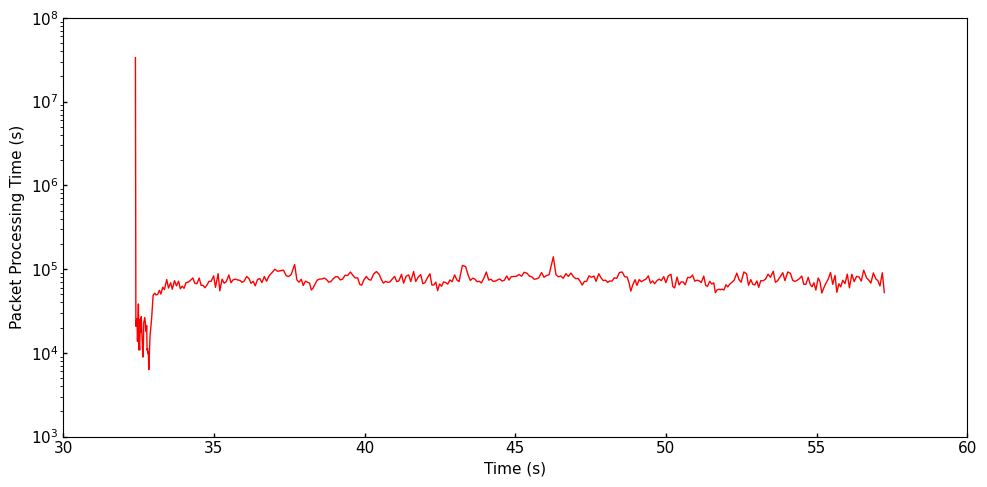

In [23]:
fastplot.plot((pkt_process_time_df['time'], pkt_process_time_df['pkt_process_time']), None, mode='line',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Time (s)',
              yscale='log')

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

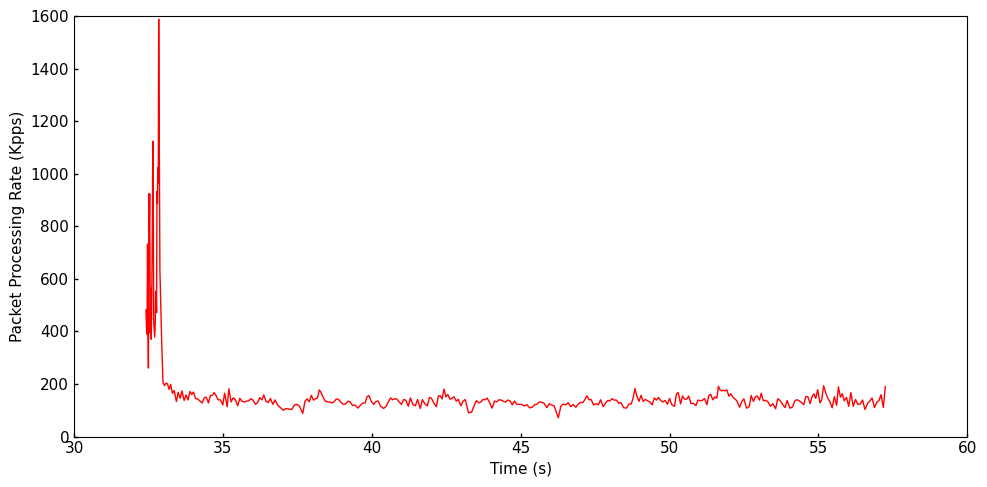

In [8]:
fastplot.plot((pkt_pps_df['time'], pkt_pps_df['kpps']), None, mode='line',
              figsize=(10, 5), xlabel='Time (s)', ylabel='Packet Processing Rate (Kpps)')

([Text(0.16037634408602147, 36700.75390010437, '75%: 80461'),
  Text(0.16021505376344086, 88318.94347759198, '95%: 91683'),
  Text(0.15602150537634407, 183436.8944295161, '99%: 108696')],
 [])

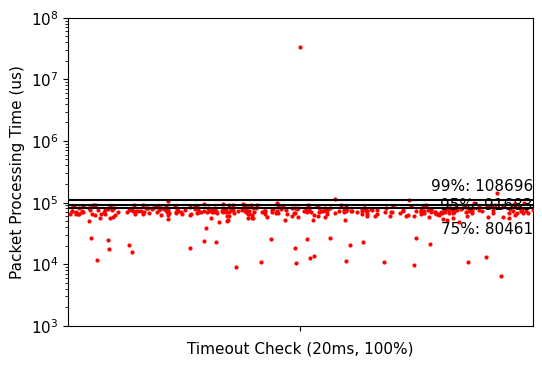

In [9]:
plt.figure(figsize=(6, 4))
sns.stripplot(y='pkt_process_time', 
              size=3, legend=False,
              data=pkt_process_time_df, jitter=0.2)
plt.ylabel('Packet Processing Time (us)')
plt.xlabel('Timeout Check (20ms, 100%)')
plt.yscale('log')


texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = pkt_process_time_df['pkt_process_time'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.25, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))

adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)


# Timeout Bias (real buffered time (avg) - expected buffered time)

In [10]:
timeout_df.head()

,time,timeout
0,32.663639,23590
1,32.979620,30169
2,33.284598,27293
3,33.615551,30150
4,33.926353,20222


([Text(0.16285282258064515, 29423.597402597406, '75%: 29521'),
  Text(0.16275201612903223, 30476.047402597407, '95%: 30573'),
  Text(0.16275201612903223, 34989.97740259741, '99%: 35087')],
 [])

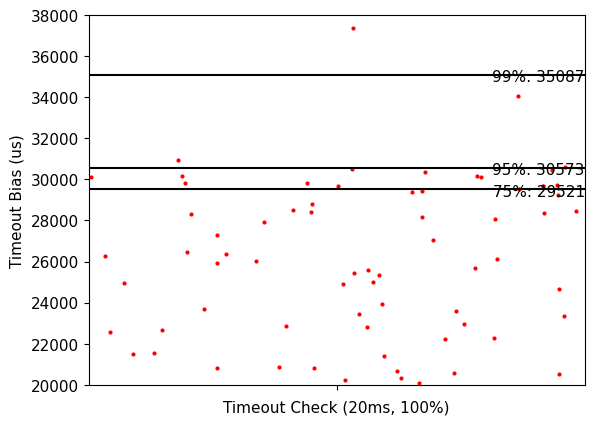

In [11]:
sns.stripplot(y='timeout', 
              size=3, legend=False,
              data=timeout_df, jitter=0.2)
plt.ylabel('Timeout Bias (us)')
plt.xlabel('Timeout Check (20ms, 100%)')
# plt.yscale('log')

texts = []
for index, ratio in enumerate(['(10ms, 1)']):
    for q in [75, 95, 99]:
        quantile = timeout_df['timeout'].quantile(q/100)
        plt.hlines(quantile, index-0.2, index+0.2, colors='black', zorder=10)
        texts.append(plt.text(index+0.4, quantile, f'{q}%: {quantile:.0f}', ha='center', va='center', color='black'))
    
adjust_text(texts, avoid_self=True, only_move={"text": "y", "static": "y", "explore": '', 'pull': ''}, explode_radius=0)

# Data Structure Usage

In [12]:
from cycler import cycler

mcolor_lists = ['red', 'red', 'blue', 'blue', 'tab:green','tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'b', 'g', 'r', 'c', 'm', 'y', 'k',
                'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'rosybrown', 'tomato', 'yellowgreen', 'lightseagreen', 'navy', 'deeppink',
                'darkslategray', 'darkolivegreen', 'darkcyan', 'darkviolet', 'mediumslateblue', 'darkorange', 'gold', 'peru', 'darkkhaki']
CYCLER_LINES=(cycler('color', mcolor_lists[:30]) +
              cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--', '-.', ':', (0, (10, 6)), (0, (6, 10)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)), (0, (3, 1, 1, 1)),
                                   '-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (1, 10)), (0,
                                                                                           (10, 6)), (0, (5, 5)), (0, (5, 10)), (0, (3, 10)),
                                   '-', '--', '-.', ':']))

<Figure size 640x480 with 0 Axes>

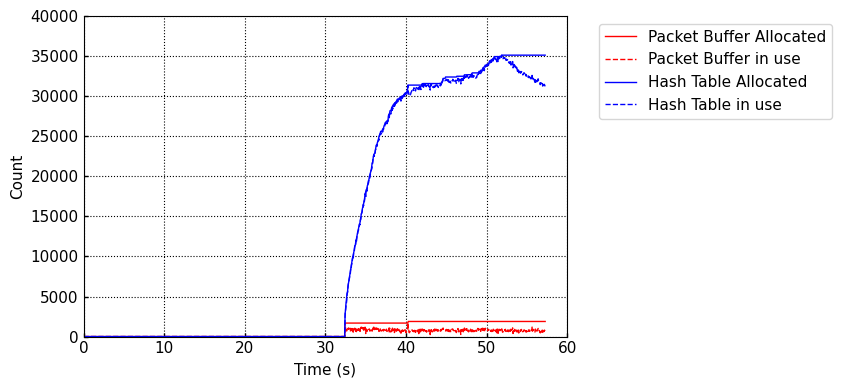

In [13]:
# buffered packet count

fastplot.plot([('Packet Buffer Allocated', (stats_df['time'], stats_df['pkt_list_count_tot'])),
              ('Packet Buffer in use', (stats_df['time'], stats_df['pkt_list_count_use'])),
               ('Hash Table Allocated', (stats_df['time'], stats_df['flow_hash_list_count_tot'])),
              ('Hash Table in use', (stats_df['time'], stats_df['flow_hash_list_count_use']))
              ],
              None,
              mode='line_multi',
              legend=True, 
              figsize=(6, 4), grid=True,
              # xlim=(stats_df['time'].min(), stats_df['time'].min() + pd.Timedelta('5 seconds')),
              # yscale='log', ylim=(10**3, 10**4),
              cycler=CYCLER_LINES,
              xlabel='Time (s)', 
              ylabel='Count')
plt.legend(loc=2, bbox_to_anchor=(1.05,1.0))


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

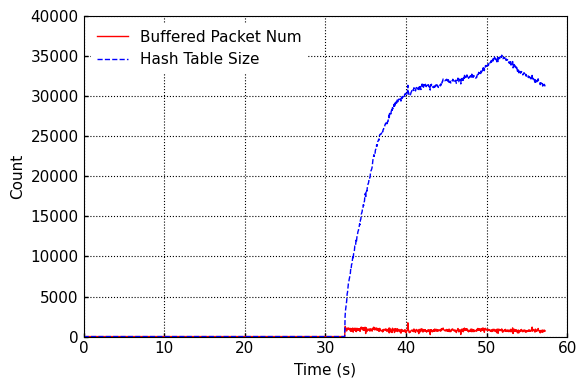

In [14]:
# buffered packet count

fastplot.plot([('Buffered Packet Num', (stats_df['time'], stats_df['pkt_buf_count'])),
              ('Hash Table Size', (stats_df['time'], stats_df['flow_hash_count']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(6, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')


<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

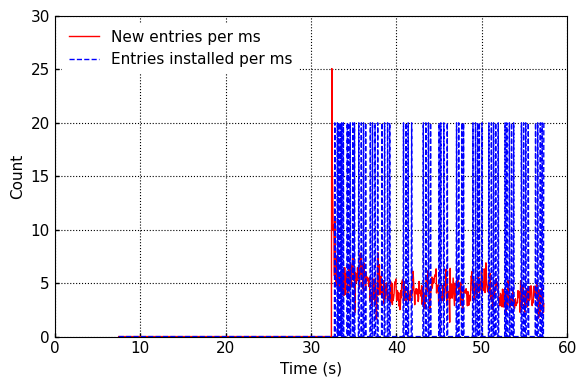

In [24]:
new_entry_cnt_ms = stats_df['replied_flow_count_tot'].diff()[1:].apply(lambda x: x/50)
instal_entry_cnt_ms = stats_df['installed_entry_count_tot'].diff()[1:].apply(lambda x: x/50)

fastplot.plot([('New entries per ms', (stats_df['time'][1:], new_entry_cnt_ms)),
                ('Entries installed per ms', (stats_df['time'][1:], instal_entry_cnt_ms))],
                None,
                mode='line_multi',
                legend=True, legend_loc='best',
                figsize=(6, 4), grid=True,
                xlabel='Time (s)', 
                ylabel='Count')

# Data Plane Resource Usage

## Table Entry Count

<module 'matplotlib.pyplot' from '/home/zhihaow/codes/honeypot_c_controller/.venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

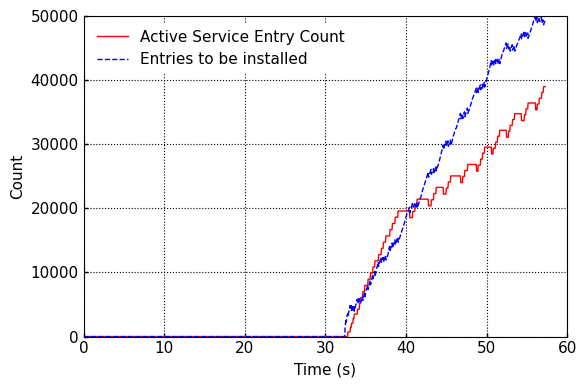

In [16]:

fastplot.plot([('Active Service Entry Count', (stats_df['time'], stats_df['active_host_tbl_entry_count'])),
               ('Entries to be installed', (stats_df['time'], stats_df['install_buf_size']))],
              None,
              mode='line_multi',
              legend=True, legend_loc='best',
              figsize=(6, 4), grid=True,
              xlabel='Time (s)', 
              ylabel='Count')

# Network Speed Statistic

In [17]:
# used for vnstat
# recv_speed_df = []

# with open('../log/recv_speed_log.json', 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         if 'jsonversion' not in line and 'maxratestring' not in line:
#             line = json.loads(line)
#             recv_speed_df.append({'time': line['seconds'], 'rx_speed': line['rx']['ratestring']})

# recv_speed_df = pd.DataFrame(recv_speed_df)
# recv_speed_df['rx_speed'] = recv_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
# recv_speed_df['rx_speed'] = recv_speed_df['rx_speed'].astype(float)

# recv_speed_df = recv_speed_df.drop(recv_speed_df[recv_speed_df['rx_speed']==0].index)
# recv_speed_df['time'] = recv_speed_df['time'] - recv_speed_df['time'].min()

# print(recv_speed_df.head())

# send_speed_df = []

# with open('../log/send_speed_log.json', 'r') as f:
#     lines = f.readlines()
#     for line in lines:
#         if 'jsonversion' not in line and 'maxratestring' not in line:
#             line = json.loads(line)
#             send_speed_df.append({'time': line['seconds'], 'tx_speed': line['tx']['ratestring']})

# send_speed_df = pd.DataFrame(send_speed_df)
# # send_speed_df['rx_speed'] = send_speed_df['rx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
# # send_speed_df['rx_speed'] = send_speed_df['rx_speed'].astype(float)
# send_speed_df['tx_speed'] = send_speed_df['tx_speed'].apply(lambda x: x.replace(' bit/s', 'e-9').replace(' kbit/s', 'e-6').replace(' Mbit/s', 'e-3').replace(' Gbit/s', ''))
# send_speed_df['tx_speed'] = send_speed_df['tx_speed'].astype(float)

# send_speed_df = send_speed_df.drop(send_speed_df[send_speed_df['tx_speed']==0].index)
# send_speed_df['time'] = send_speed_df['time'] - send_speed_df['time'].min()

# send_speed_df.head()

In [18]:
# def unit_conversion(bit):
#     bit = int(bit)
#     if bit > 1000:
#         res = bit / 1000
#         if res < 1000:
#             res = float('%.2f' % res)
#             return str(res) + 'K'
#         elif res < 1000 * 1000:
#             res = res / 1000
#             res = float('%.2f' % res)
#             return str(res) + 'M'
#         else:
#             res = res / (1000 * 1000)
#             res = float('%.2f' % res)
#             return str(res) + 'G'
#     else:
#         return str(bit)

In [19]:
# def bit_to_Gbit(bit):
#     return bit / (1000 * 1000 * 1000)

# def bit_to_Mbit(bit):
#     return bit / (1000 * 1000)

# def byte_to_Gbit(byte):
#     return byte * 8 / (1000 * 1000 * 1000)

In [20]:
# net_stat_df = pd.read_csv('../log/net_stat.csv')
# net_stat_df['bits_recv'] = net_stat_df['bits_recv'].apply(bit_to_Gbit)
# net_stat_df['bits_sent'] = net_stat_df['bits_sent'].apply(bit_to_Gbit)
# net_stat_df['packets_recv'] = net_stat_df['packets_recv'].apply(bit_to_Mbit)
# net_stat_df['packets_sent'] = net_stat_df['packets_sent'].apply(bit_to_Mbit)
# net_stat_df['time'] = net_stat_df['time'] - net_stat_df['time'].min()

In [21]:
# fastplot.plot([
#     # ('Sending Speed', (send_speed_df['time'], send_speed_df['tx_speed'])),
#               ('Receiving Data Rate', (net_stat_df['time'], net_stat_df['bits_recv'])),
#               ('Sending Data Rate', (net_stat_df['time'], net_stat_df['bits_sent']))],
#                 None,
#                 mode='line_multi',
#                 legend=True, legend_loc=[0.6, 0.25],
#                 figsize=(6, 4), grid=True,
#                 xlabel='Time (s)', 
#                 ylabel='Data Rate (Gbps)')

In [22]:
# fastplot.plot([
#     # ('Sending Speed', (send_speed_df['time'], send_speed_df['tx_speed'])),
#               ('Receiving PPS', (net_stat_df['time'], net_stat_df['packets_recv'])),
#               ('Sending PPS', (net_stat_df['time'], net_stat_df['packets_sent']))],
#                 None,
#                 mode='line_multi',
#                 legend=True, legend_loc=[0.6, 0.25],
#                 figsize=(6, 4), grid=True,
#                 xlabel='Time (s)', 
#                 ylabel='Data Rate (Mpps)')